In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../common')

In [3]:
import os
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pandas

from tectosaur.mesh.combined_mesh import CombinedMesh

import collect_dem
import mesh_fncs
import inverse_tools

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['text.latex.preamble'] = '\\usepackage{amsmath}'

In [7]:
continuous_gps = pandas.read_csv('input_data/wenchuan_continuous', sep = ' ')
campaign_gps = pandas.read_csv('input_data/wenchuan_campaign', sep = ' ')
triangulation = pandas.read_csv('input_data/wenchuan_triangulation', sep = ' ')

In [8]:
def get_all(col_name):
    return np.array(
        continuous_gps[col_name].tolist()
        + campaign_gps[col_name].tolist()
        + triangulation[col_name].tolist()
    )

In [9]:
continuous_gps.shape, campaign_gps.shape, triangulation.shape

((38, 12), (435, 14), (33, 12))

In [10]:
zoom = 5
proj = 'utm48R'
n_dem_interp_pts = 300

In [11]:
cols = ['Lon', 'Lat', 'EW', 'SN', 'Sew', 'Sns']
data = pandas.DataFrame(np.array([get_all(c) for c in cols]).T, columns = cols)
proj_pts = collect_dem.project(np.array(data['Lon']), np.array(data['Lat']), 0 * np.array(data['Lat']), proj)
data['X'] = proj_pts[:,0]
data['Y'] = proj_pts[:,1]

48R


In [12]:
data.shape

(506, 8)

In [10]:
surf, fault = np.load('wenchuan_base_mesh.npy')
full_m = CombinedMesh.from_named_pieces([('surf', surf), ('fault', fault)])

zoom = 5
proj = 'utm48R'
n_dem_interp_pts = 300

m_with_topo = mesh_fncs.set_surf_elevations(full_m, n_dem_interp_pts, zoom, proj)

#inverse_tools.plot_situation(m_with_topo, view_R = 6.0)

m_refined = mesh_fncs.set_surf_elevations(m_with_topo.refine().refine(), n_dem_interp_pts * 2, zoom + 1, proj)
m_refined.n_tris()
np.save('refined_mesh.npy', m_refined)

48R
downloading dem data for bounds = (23.746674739588322, 94.451583008922896, 39.205777960890885, 113.54220614617404) and zoom = 5
5 24 12
5 25 12
5 26 12
5 24 13
5 25 13
5 26 13
48R
48R
downloading dem data for bounds = (23.746674739588322, 94.451583008922896, 39.205777960890885, 113.54220614617404) and zoom = 6
6 48 24
6 49 24
6 50 24
6 51 24
6 52 24
6 48 25
6 49 25
6 50 25
6 51 25
6 52 25
6 48 26
6 49 26
6 50 26
6 51 26
6 52 26
6 48 27
6 49 27
6 50 27
6 51 27
6 52 27
48R


In [13]:
m_refined = np.load('refined_mesh.npy').tolist()

In [14]:
def fix_data():
    data_fixed_wrong = data.copy()
    on_the_wrong_side = np.where(np.logical_and.reduce((
        data['X'] < 440000, 438000 < data['X'], 
        3508000 < data['Y'], data['Y'] < 3508500
    )))
    data_fixed_wrong['X'][on_the_wrong_side[0][0]] -= 200
    data_fixed_wrong['Y'][on_the_wrong_side[0][0]] += 200
    # %matplotlib notebook
    # inverse_tools.plot_situation(
    #     m_refined, data_fixed_wrong, view_R = 1.6,
    #     min_elevation = 0.0, max_elevation = 5.5, latlon_step = 1.0
    # )
    return data_fixed_wrong
# data = fix_data()

48R
48R
48R
48R


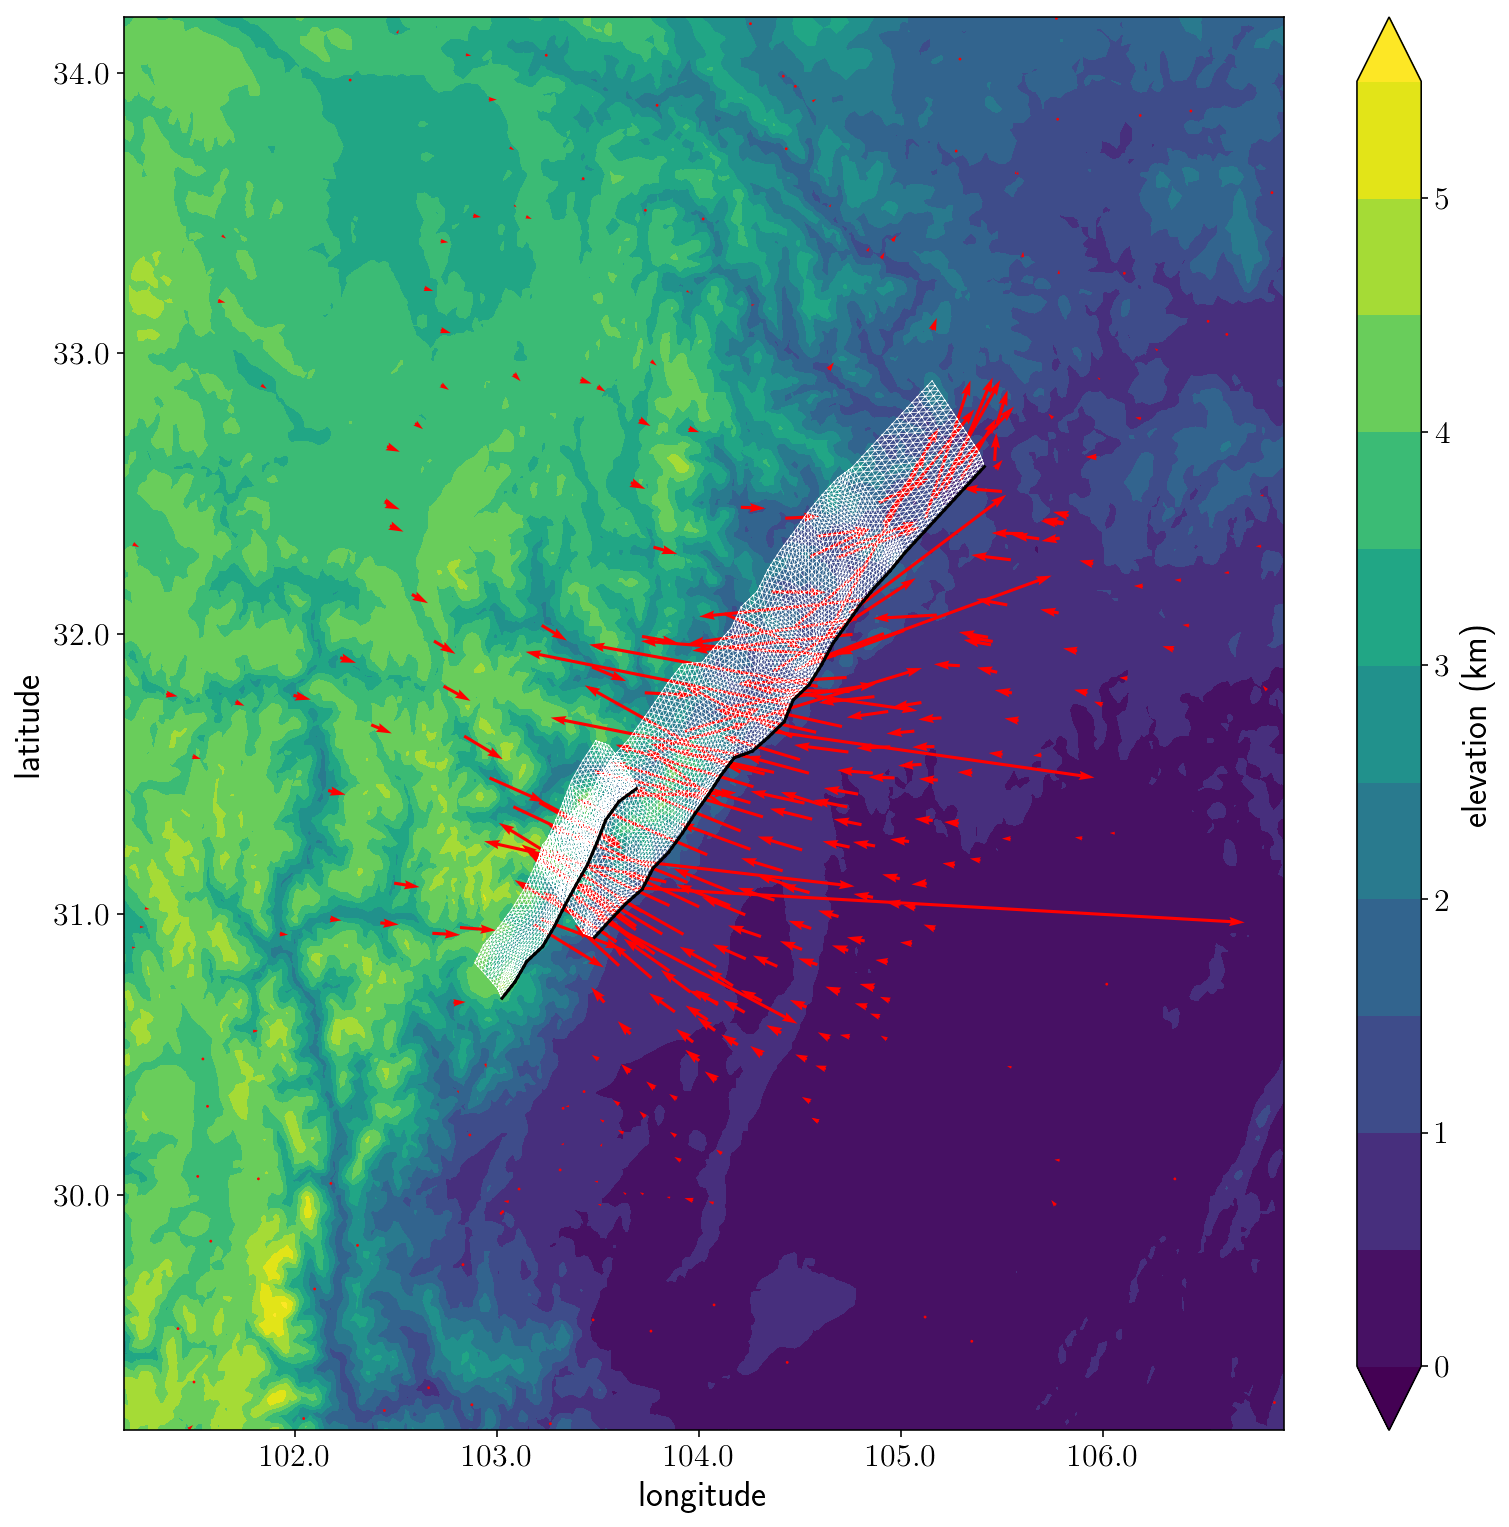

In [15]:
inverse_tools.plot_situation(
    m_refined, data, #filename = 'wenchuan_map.pdf', 
    proj = proj, view_R = 1.6,
    min_elevation = 0.0, max_elevation = 5.5, latlon_step = 1.0
)

In [16]:
m_xyz = mesh_fncs.to_sphere_xyz(m_refined, proj)
np.save('m_xyz.npy', [m_xyz.pts, m_xyz.tris])

48R


In [17]:
inverse_proj = 'ellps'
m_inverse = m_xyz
tol = 5e-4

def get_vertical(pts):
    # radial direction
    center = np.mean(pts, axis = 0)
    vertical_unit_vector = center / np.linalg.norm(center)
    return vertical_unit_vector

In [18]:
tol = 7e-4
filename = str(tol) + '_xyz_inverse_soln.npy'

In [12]:
integral_eqs = inverse_tools.assemble_integral_eqs(m_inverse)

[21165:INFO:tectosaur_topo]
    forward_assemble configuration: 
{'float_type': <class 'numpy.float32'>,
 'fmm_mac': 3.0,
 'fmm_order': 150,
 'log_level': 20,
 'preconditioner': 'ilu',
 'pts_per_cell': 450,
 'quad_far_order': 2,
 'quad_mass_order': 3,
 'quad_near_order': 5,
 'quad_near_threshold': 2.0,
 'quad_vertadj_order': 6,
 'use_fmm': True}
[114975:INFO:tectosaur.util.cuda]
    Initialized CUDA on gpu: 0
[567892:INFO:tectosaur_topo]
    adjoint_assemble configuration: 
{'float_type': <class 'numpy.float32'>,
 'fmm_mac': 3.0,
 'fmm_order': 150,
 'log_level': 20,
 'preconditioner': 'ilu',
 'pts_per_cell': 450,
 'quad_far_order': 2,
 'quad_mass_order': 3,
 'quad_near_order': 5,
 'quad_near_threshold': 2.0,
 'quad_vertadj_order': 6,
 'use_fmm': True}


In [13]:
proj_rotate = inverse_tools.build_proj_rotate(m_xyz, inverse_proj, proj)

48R


In [14]:
to_obs, rhs, pts_inside = inverse_tools.setup_data_matrices(m_refined, data, [0, 1])
soln_to_obs = to_obs.dot(proj_rotate)
slip_matrix = inverse_tools.build_slip_matrix(m_inverse, get_vertical = get_vertical)

number of observation points outside the surface mesh: 2


In [15]:
inverse_soln = inverse_tools.inversion(integral_eqs, soln_to_obs, rhs, slip_matrix, tol)
np.save(filename, inverse_soln)

[1127798:INFO:tectosaur_topo]
    forward_solve configuration: 
{'log_level': 20, 'solver_tol': 1e-08}
[1139453:INFO:tectosaur_topo]
    forward_solve configuration: 
{'log_level': 20, 'solver_tol': 1e-08}
 
LSMR            Least-squares solution of  Ax = b

The matrix A has     1008 rows  and    42048 cols
damp = 0.00000000000000e+00

atol = 7.00e-04                 conlim = 1.00e+08

btol = 7.00e-04             maxiter =     1008

[1147992:INFO:tectosaur_topo]
    adjoint_solve configuration: 
{'log_level': 20, 'solver_tol': 1e-08}
 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.234e+03  9.324e+01   1.0e+00  6.1e-05
[1168871:INFO:tectosaur_topo]
    forward_solve configuration: 
{'log_level': 20, 'solver_tol': 1e-08}
[1189228:INFO:tectosaur_topo]
    adjoint_solve configuration: 
{'log_level': 20, 'solver_tol': 1e-08}
     1 -1.02476e+00  1.015e+03  5.984e+01   8.2e-01  4.9e-01  1.2e-01  8.3e+00
[1206753:INFO:tectosaur_topo]
   

In [19]:
inverse_soln = np.load(filename)

48R
48R
48R
48R


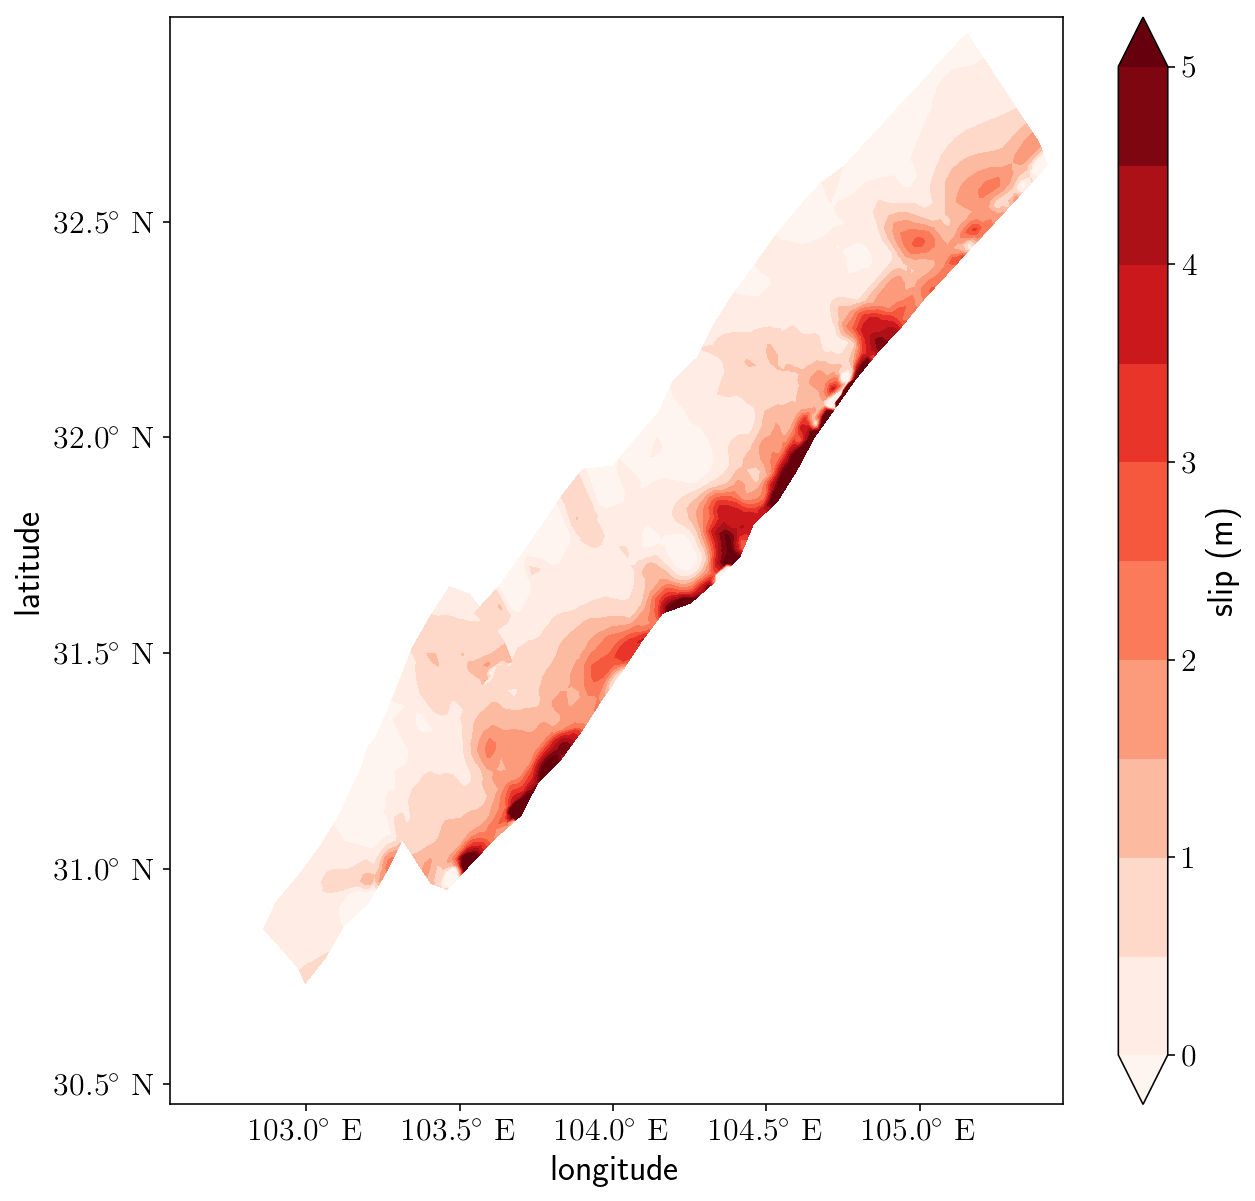

48R
48R
48R
48R


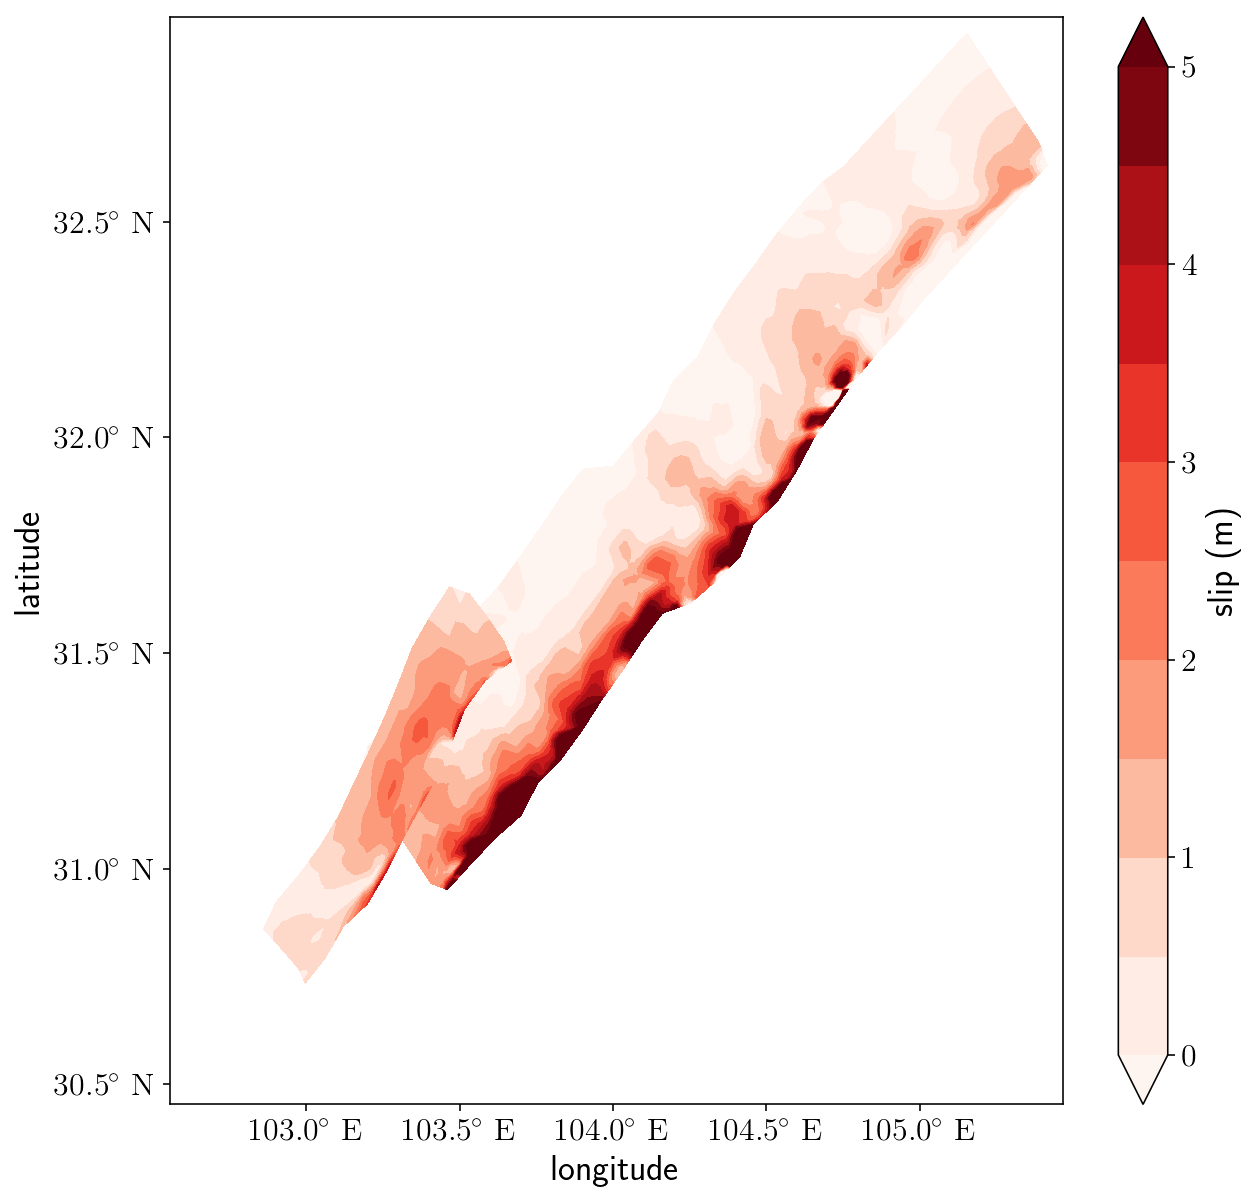

In [23]:
for comp in range(2):
    vert_vals = inverse_tools.get_vert_vals_linear(
        (m_refined.pts, m_refined.get_tris('fault')), 
        inverse_soln[0].reshape((-1,2))[:,comp].reshape((-1,3))
    )
    vert_vals = vert_vals / 100.
    if comp == 0:
        vert_vals *= -1

    plt.figure(figsize = (10,10))
    sdim = [1,2]
    plt.triplot(m_refined.pts[:,sdim[0]], m_refined.pts[:,sdim[1]], m_refined.get_tris('fault'), 'k-', linewidth = 0.1)
    # plt.tripcolor(
    #     m_refined.pts[:,0], m_refined.pts[:,1], 
    #     m_refined.get_tris('fault'), soln[:,comp].reshape((-1,3))[:,0], 
    #     'k-', vmin = -200, vmax = 0
    # )
    sdim = [0,1]
    levels = np.linspace(0, 5, 11)
    cntf = plt.tricontourf(
        m_refined.pts[:,sdim[0]], m_refined.pts[:,sdim[1]], 
        m_refined.get_tris('fault'), vert_vals, 
        levels = levels, extend = 'both', cmap = 'Reds'
    )
#     plt.tricontour(
#         m_refined.pts[:,sdim[0]], m_refined.pts[:,sdim[1]], 
#         m_refined.get_tris('fault'), vert_vals, 
#         levels = levels,
#         colors = '#333333', linestyles = 'solid', linewidths = 1.0
#     )
    fault_pts = m_refined.get_tri_pts('fault').reshape((-1,3))
    fC = np.mean(fault_pts, axis = 0)
    R = np.sqrt(np.max(np.sum((fault_pts - fC) ** 2, axis = 1)))
    view_R = 0.8
    xbounds = [fC[sdim[0]] - view_R * R, fC[sdim[0]] + view_R * R]
    ybounds = [fC[sdim[1]] - view_R * R, fC[sdim[1]] + view_R * R]
    inverse_tools.latlon_axis(plt.gca(), xbounds, ybounds, proj, 0.5)
    plt.xlim(xbounds)
    plt.ylim(ybounds)
    cbar = plt.colorbar(cntf)
    cbar.set_label('$\\text{slip (m)}$')
    plt.savefig(['strike','dip'][comp] + '-slip-040618.pdf')
    plt.show()

In [19]:
u_surf, data_modeled = inverse_tools.calc_modeled_data(integral_eqs, soln_to_obs, slip_matrix, inverse_soln)

[3338634:INFO:tectosaur_topo]
    forward_solve configuration: 
{'log_level': 20, 'solver_tol': 1e-08}


In [20]:
modeled = np.zeros((data['SN'].shape[0], 2))
modeled[pts_inside[:,0]] = data_modeled.reshape((-1,2))

In [21]:
np.mean(np.abs(rhs - data_modeled)), np.mean(np.abs(data['Sew']))

(2.167282502413546, 0.70018181818181813)

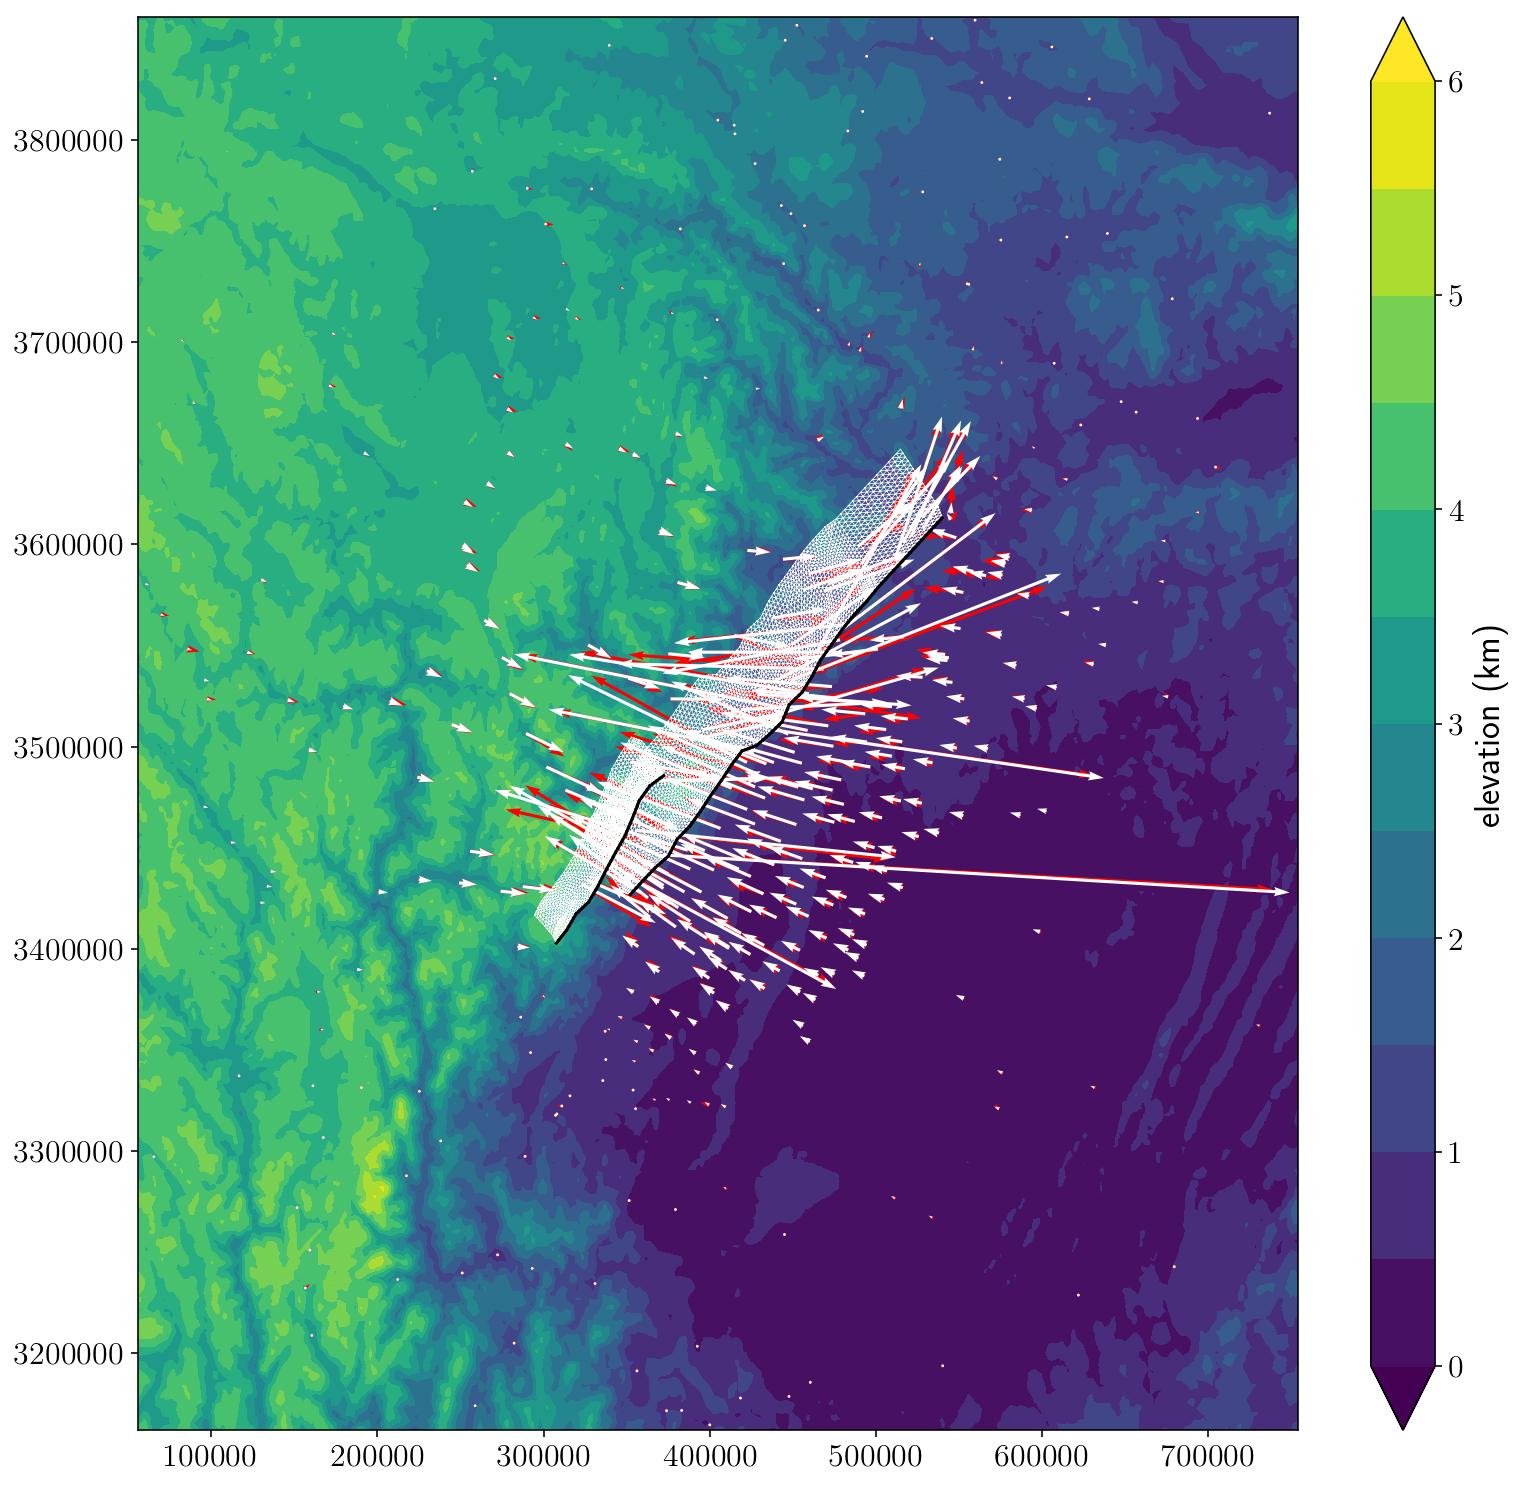

In [22]:
inverse_tools.plot_situation(m_refined, data, modeled = modeled)

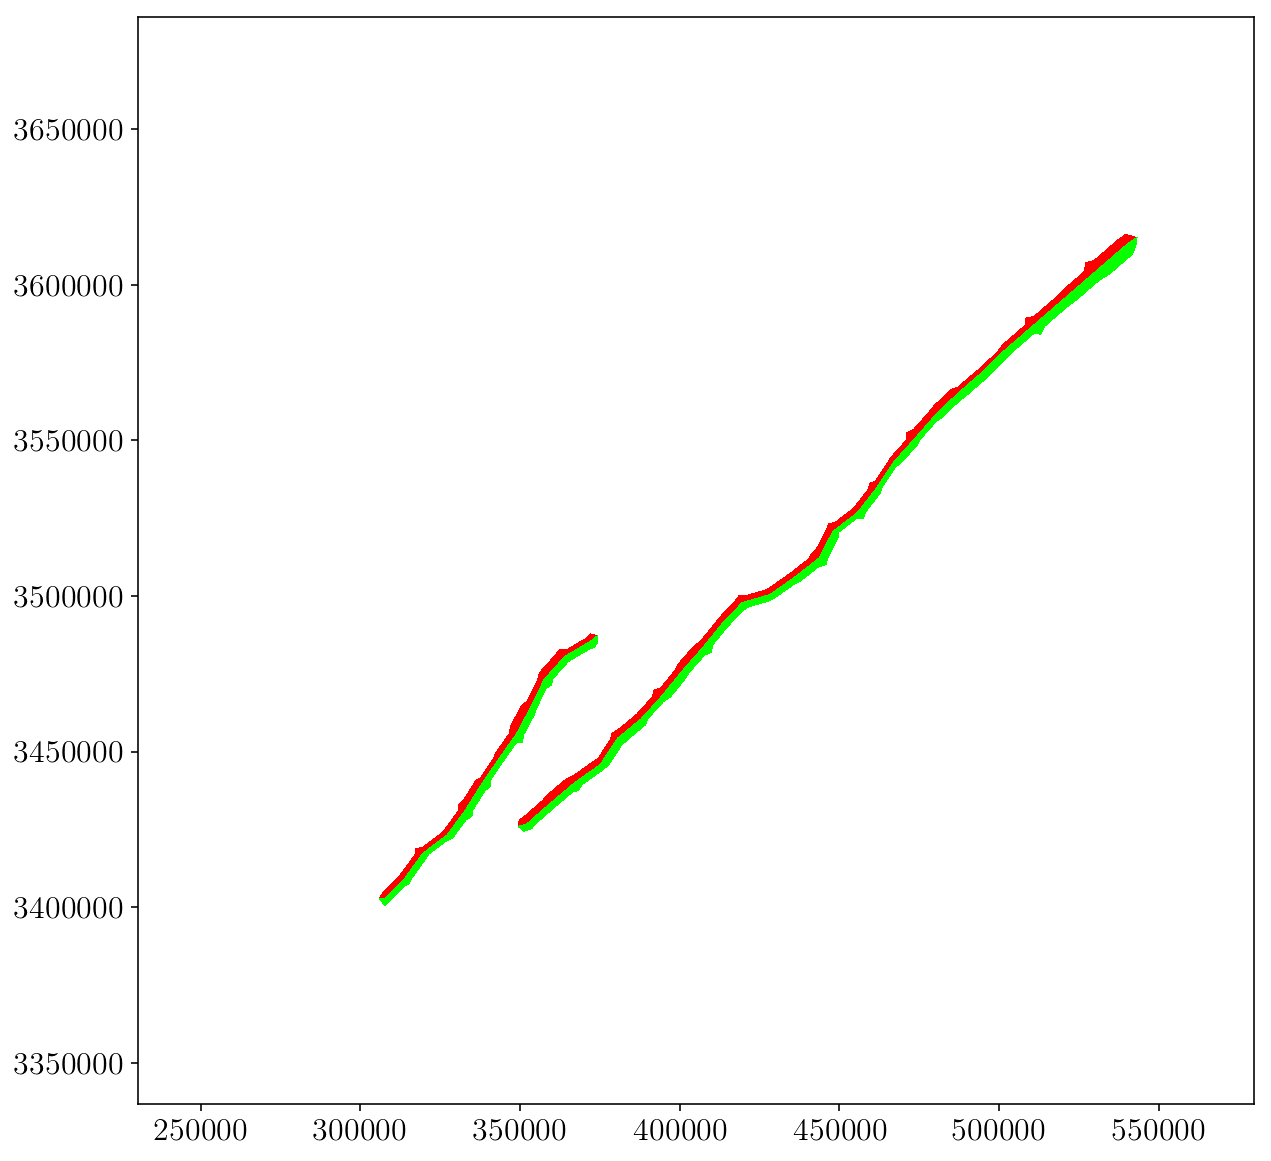

In [23]:
side = inverse_tools.get_side_of_fault(m_refined)
inverse_tools.plot_side_of_fault(m_refined, side)

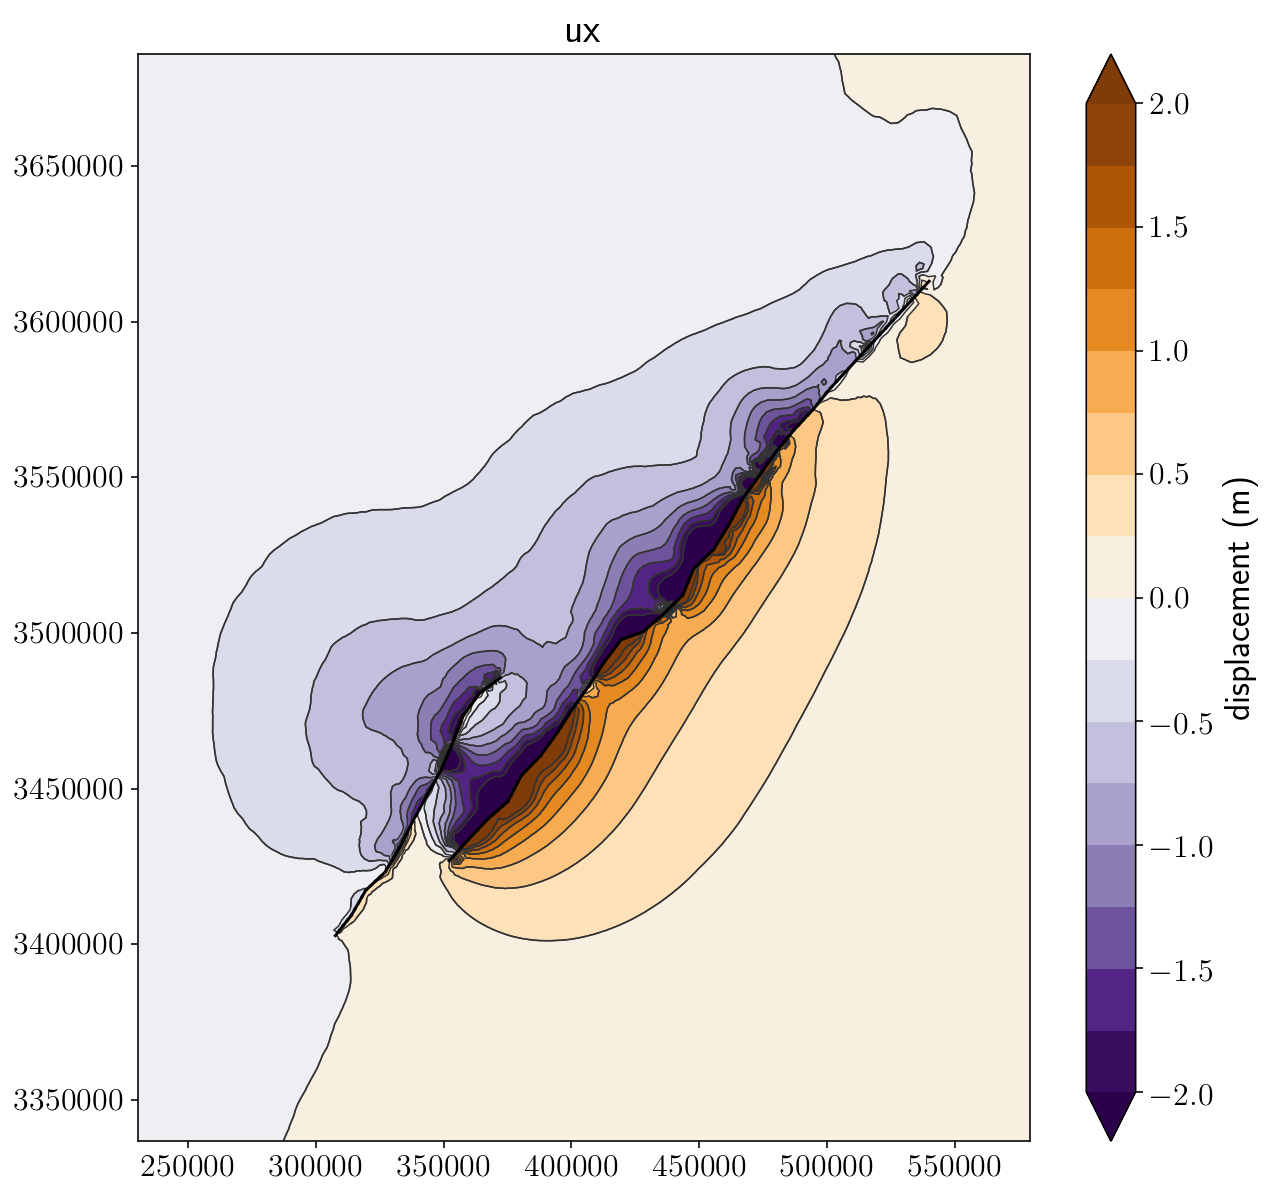

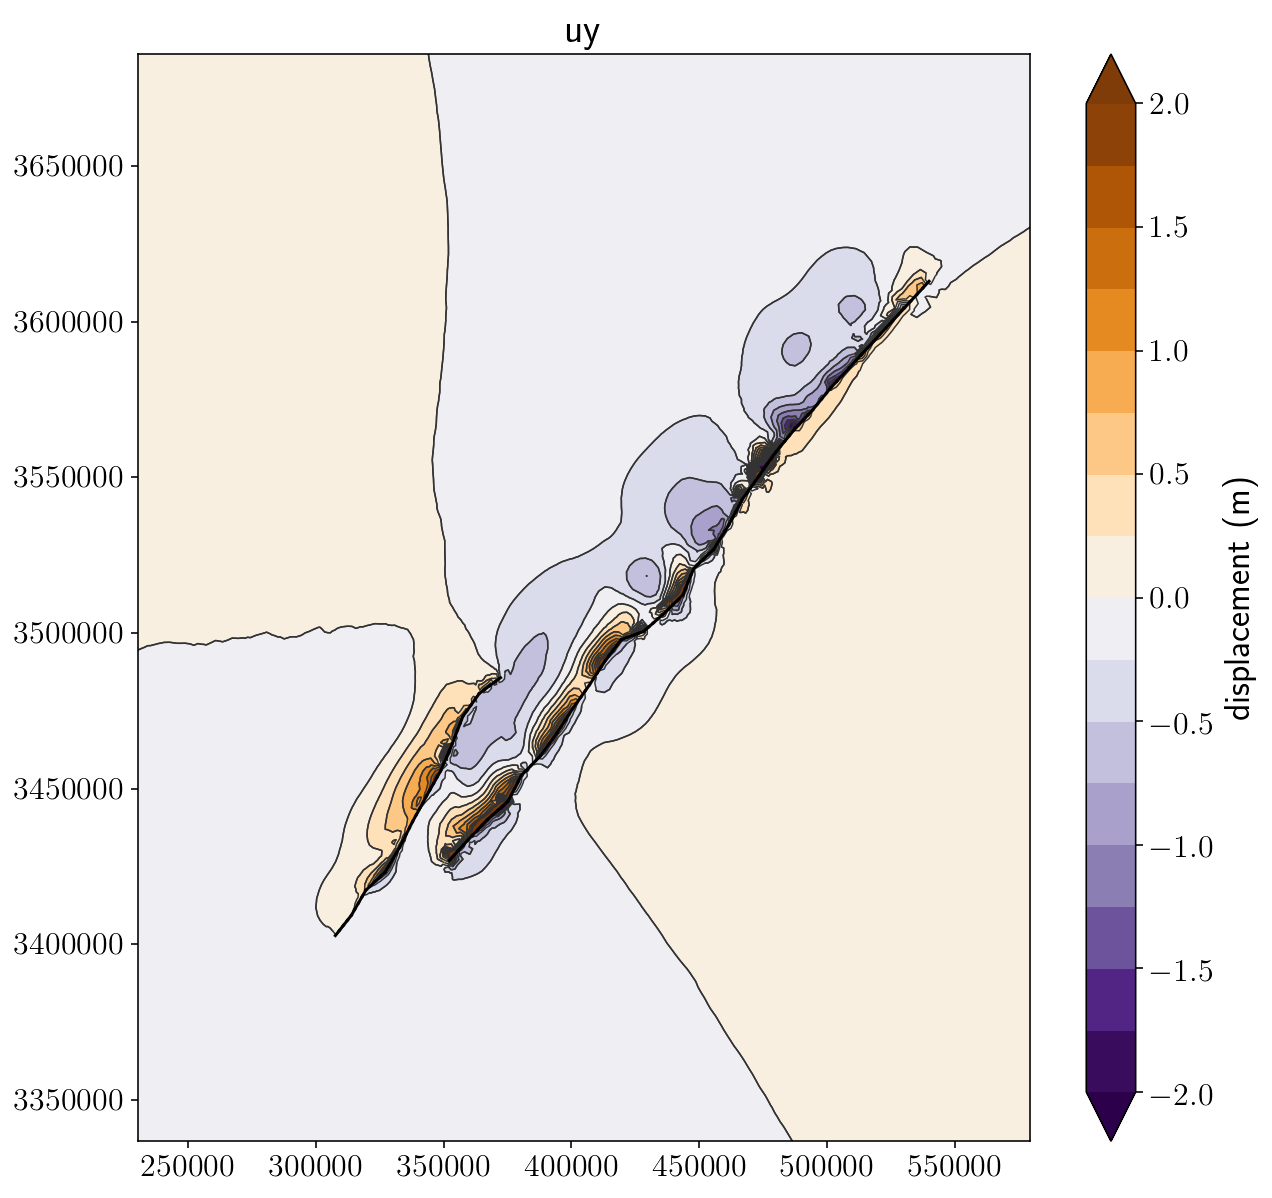

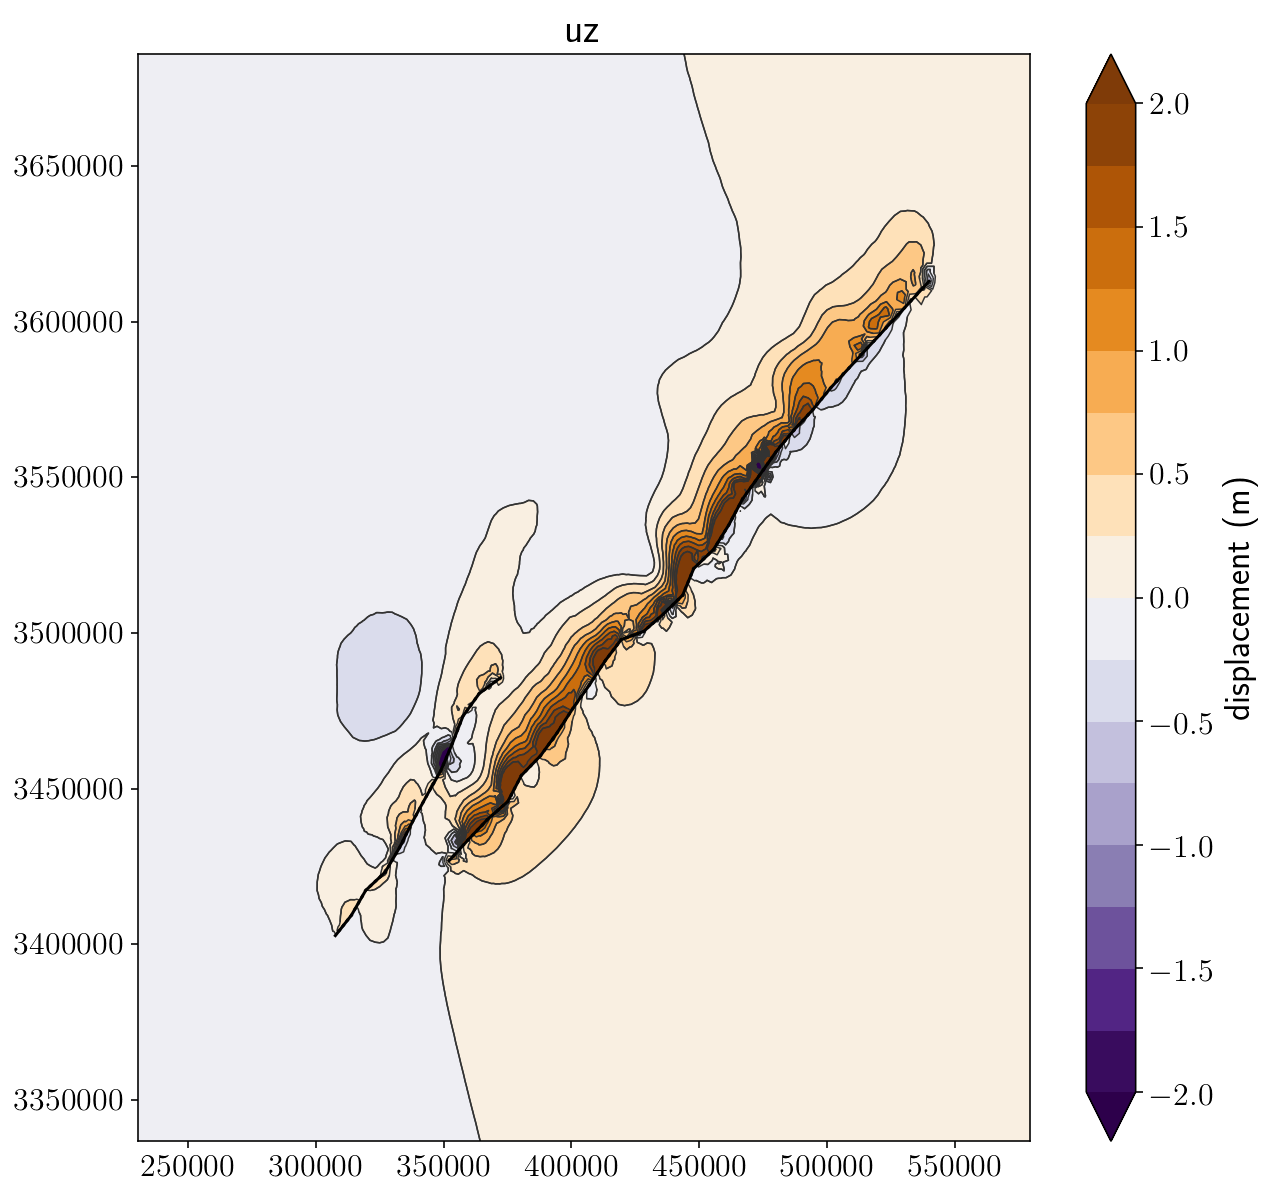

In [24]:
for d in range(3):
    name = 'u' + ['x','y','z'][d]
    field = m_refined.get_dofs(u_surf, 'surf').reshape((-1,3,3))[:,:,d] / 100.0
    vmin = -2.0
    vmax = 2.0
    inverse_tools.plot_surf_disp(m_refined, side, field, name, vmin = vmin, vmax = vmax, view_R = 1.0)

In [25]:
tri_depth, avg_tri_moment = inverse_tools.moment_analysis(m_refined, inverse_soln, proj)

potency: 25329514449.7
M0: 7.59885433492e+20
M: 7.88716541297
48R
downloading dem data for bounds = (30.52991863563965, 102.60673294000735, 33.168544012185819, 105.66884936818037) and zoom = 5
5 25 12
5 25 13


In [35]:
np.save('moment_vs_depth.npy', [tri_depth, avg_tri_moment])

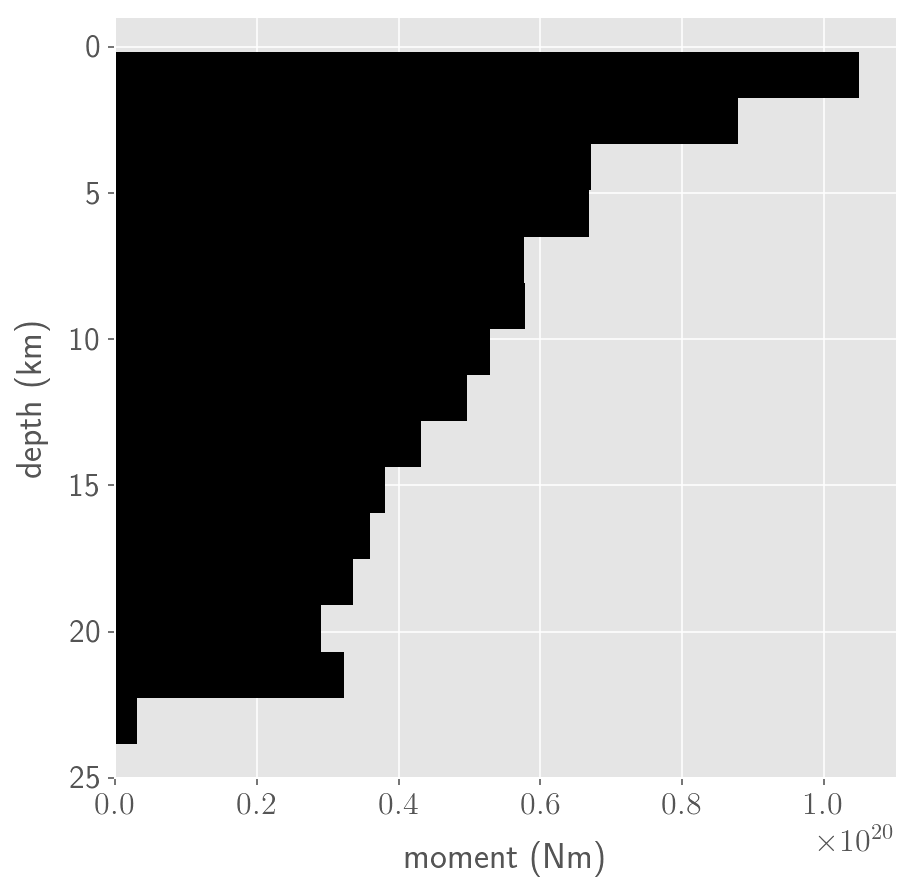

In [34]:
inverse_tools.plot_moment_analysis(tri_depth, avg_tri_moment)